In [2]:
import numpy as np
np.random.seed(523)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

In [19]:
def plot_roc (model, X, y):
    
    # model=lasso1
    # X = X_test_scaled
    # y = y_test

    # probabilities of ckd
    ckd_probs=model.predict_proba(X)[:,1]

    oneminusspec_list=[]
    sensitivity_list=[]

    threshes=np.linspace(0,1, 100)
    for thresh in threshes:
     
        # initialize the confusion matrix tally for this particular threshold
        TP=0
        FP=0
        FN=0
        TN=0
    
        # For every threshold, compute the confusion matrix values
        for obs_num in range(len(y)):
            if ckd_probs[obs_num]>=thresh:
                predict_sick=True
            else:
                predict_sick=False

            if y[obs_num]==1:
                sick=True
            else:
                sick=False

            if predict_sick and sick:
                TP += 1
            elif predict_sick and not sick:
                FP += 1
            elif not predict_sick and sick:
                FN += 1
            else:
                TN += 1

        # For every threshold, compute and record the oneminusspec
        # value and the sensitivity value
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
        oneminusspec = 1 - specificity

        oneminusspec_list.append(oneminusspec)
        sensitivity_list.append(sensitivity)


    oneminusspec_list=list(reversed(oneminusspec_list))
    sensitivity_list=list(reversed(sensitivity_list))

    oneminusspec_list
    sensitivity_list

    figure, ax = plt.subplots(figsize=(7,7))
    plt.plot(oneminusspec_list, sensitivity_list)
    x=np.linspace(0,1, num=50)
    y=x
    plt.plot(x,y, 'r')
    plt.plot()
    ax.set_xlabel("False positive rate", fontsize=20)
    ax.set_ylabel("Sensitivity", fontsize=20)

# Predicting whether a message is from an evolution or creationism discussion group

## 1. TrainTestSplit 

In [3]:
df=pd.read_pickle('./evol_pickle')

In [4]:
X=df['body']
y =df['class']

# Evolution is Class 0
# Creationism is Class 1

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.3,
                                                   random_state=42)

In [6]:
y_train.shape

(6224,)

## 2. Naive Bayes Model

In [7]:
# This is the baseline accuracy score

baseline=y_train.value_counts().max()/y_train.shape[0]
baseline

0.5965616966580977

In [8]:
y_train.value_counts()

0    3713
1    2511
Name: class, dtype: int64

In [9]:
pipeline = Pipeline([
    
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('bayes', MultinomialNB())
])


In [10]:
hyperparameters={ 
                'tfidf__use_idf': [True],
                 'vect__max_df': [0.005],
                 'vect__ngram_range': [(1,1)]
                }

grid = GridSearchCV(pipeline, hyperparameters, cv=3)

In [11]:
_=grid.fit(X_train, y_train)

In [12]:
grid.best_params_

{'tfidf__use_idf': True, 'vect__max_df': 0.005, 'vect__ngram_range': (1, 1)}

In [13]:
grid.score(X_train, y_train)

0.8713046272493573

In [14]:
grid.score(X_test, y_test)

0.6990254872563718

In [15]:
tn, fp, fn, tp = confusion_matrix(y_test, grid.predict(X_test)).ravel()

In [16]:
# Specificity

tn/(fp+tn)

0.9529485570890841

In [17]:
# Sensitivity

tp/(fn+tp)

0.3221601489757914

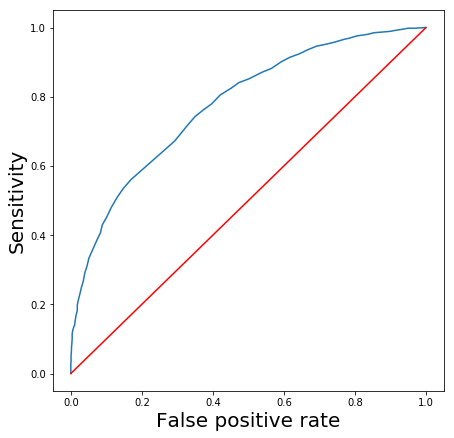

In [20]:
plot_roc(grid, X_test, y_test.ravel())


In [22]:
f1_score(y_test, grid.predict(X_test))

0.462876254180602

In [23]:
vectorizer=CountVectorizer(max_df=0.005, ngram_range=(1, 1))

In [24]:
transformer=TfidfTransformer()

In [25]:
bayes=MultinomialNB()

In [26]:
one=vectorizer.fit_transform(X_train)

In [27]:
two=transformer.fit_transform(one)

In [28]:
bayes.fit(two, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [29]:
coefs=(pd.DataFrame(bayes.feature_log_prob_).T)
coefs=coefs.rename(columns={0:'evolution log-odds', 1:'creation log-odds'})
coefs['vocabulary']=vectorizer.get_feature_names()

In [30]:
coefs['diff']=coefs['evolution log-odds']-coefs['creation log-odds']

In [31]:
coefs['abs diff']=coefs['diff'].abs()

In [32]:
def label(x):
    if x>0:
        return "distinctively pro-evolution"
    else:
        return "distinctively pro-creationism"

In [33]:
coefs['label']=coefs['diff'].map(label)

In [34]:
coefs.sort_values(by='abs diff', ascending=False)[['vocabulary', 'label']][:50]

,vocabulary,label
1993,biogenesis,distinctively pro-evolution
16878,ribosomes,distinctively pro-evolution
17464,scripture,distinctively pro-creationism
6732,epistemology,distinctively pro-evolution
45,abiotic,distinctively pro-evolution
13688,omniscient,distinctively pro-creationism
13593,oec,distinctively pro-creationism
10807,johnberea,distinctively pro-evolution
12672,morning,distinctively pro-creationism
16967,rnas,distinctively pro-evolution


In [35]:
evolution_vocab=list(coefs.sort_values(by='evolution log-odds', ascending=False)['vocabulary'])[:50]

In [36]:
creationism_vocab=list(coefs.sort_values(by='creation log-odds', ascending=False)['vocabulary'])[:50]

In [37]:
evolution_vocab

['epistemology',
 'biogenesis',
 'ribosomes',
 'johnberea',
 'abiotic',
 'mendel',
 'idiot',
 'color',
 'ring',
 'precursors',
 'allele',
 'rebuttal',
 'bot',
 'troll',
 'holy',
 'muh',
 'ken',
 'tries',
 'crap',
 'answered',
 'bullshit',
 'dishonesty',
 'dude',
 'consciousness',
 'tiktaalik',
 'im',
 'rnas',
 'uh',
 'biosphere',
 'racist',
 'transitions',
 'meta',
 'primates',
 'virgin',
 'male',
 'somebody',
 'mice',
 'speculation',
 'mobile',
 'races',
 'addressing',
 'threads',
 'dying',
 'cats',
 'philosophers',
 'ham',
 'formal',
 'mod',
 'informed',
 'imgur']

In [38]:
creationism_vocab

['scripture',
 'omniscient',
 'oec',
 'morning',
 'decay',
 'soul',
 'doesnt',
 'evening',
 'worldview',
 'star',
 'pm',
 'multiverse',
 'butter',
 'bread',
 'glad',
 'eugenics',
 'letter',
 'downvoting',
 'names',
 'access',
 'sin',
 'treat',
 'younger',
 'fascinating',
 'fudge',
 'mechanics',
 'blog',
 'private',
 'confused',
 'gas',
 'im',
 'secret',
 'motivation',
 'mainstream',
 'dated',
 'image',
 'decide',
 'night',
 'seemed',
 'destroyed',
 'serve',
 'student',
 'emotion',
 'government',
 'viewpoint',
 'friends',
 'neccessarily',
 'contamination',
 'online',
 'phd']